In [1]:
import os

import cv2 
from PIL import Image
import matplotlib.pyplot as plt 

import pandas as pd 
import numpy as np

from skimage.feature import local_binary_pattern
from skimage.feature import hog

In [2]:
root_dir = "/media/data/Project_Only/MLOps/face-rec-avenger/data/01_raw" 

<BarContainer object of 5 artists>

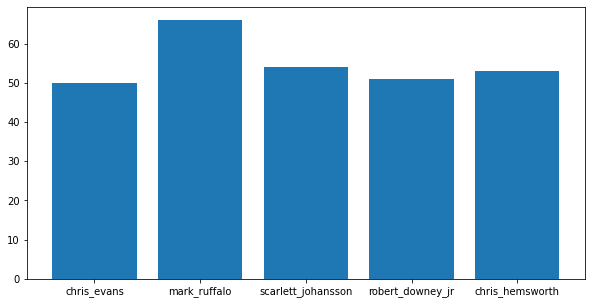

In [94]:
img_counts = []
img_folders = []

for img_folder in os.listdir(root_dir):
    img_folder = os.path.join(root_dir, img_folder)
    img_folders.append(img_folder)
    
    count = 0
    for i, img in enumerate(os.listdir(img_folder)):
        count += 1
    img_counts.append(count)

name_only = [name.split("/")[2] for name in img_folders]
    
f = plt.figure(figsize=(10,5))
plt.bar(name_only, img_counts)

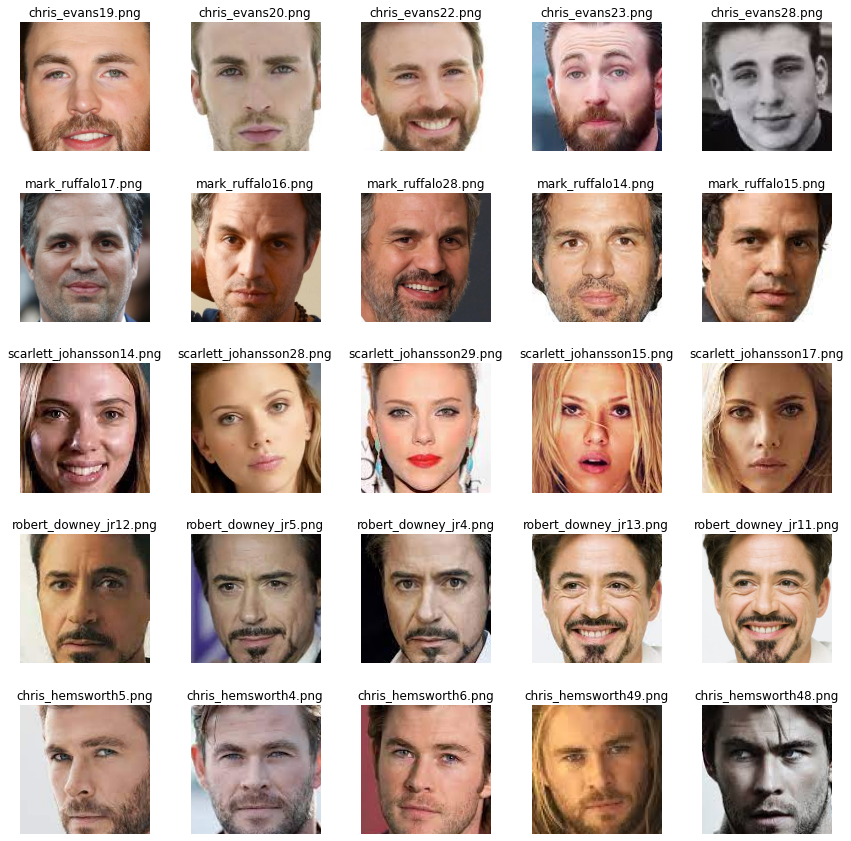

In [95]:
# Plot imgs 
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
fig.tight_layout()
axs = axs.ravel()

for i, img_folder in enumerate(img_folders):
    for j, filename in enumerate(os.listdir(img_folder)):
        if j < 5:
            # Load and display the image.
            image = np.asarray(Image.open(os.path.join(img_folder, filename)))
            axs[i*5+j].imshow(image)
            axs[i*5+j].axis("off")
            axs[i*5+j].set_title(filename)
            
plt.show()

In [96]:
# Check size and format of images
images = []
size_images = []
for i, img_folder in enumerate(img_folders):
    for j, filename in enumerate(os.listdir(img_folder)):
        img = np.asarray(Image.open(os.path.join(img_folder, filename)))
        size_images.append(img.shape)
        images.append(img)
        
size_images.sort()
print("Largest size:", size_images[-1])
print("Smallest size:", size_images[0])

Largest size: (1754, 1754, 3)
Smallest size: (58, 58, 3)


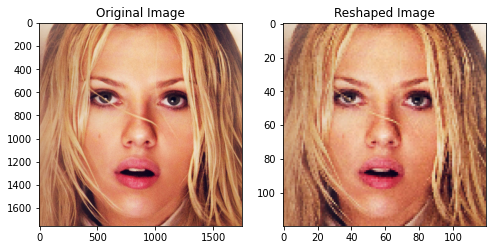

In [97]:
# Sort the image.
sorted_images = sorted(images, key=lambda x: len(x))

# Reshape the image.
img_reshaped_largest = cv2.resize(sorted_images[-1], (120, 120))

# Display the original and reshaped images side by side.
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# original image
axs[0].imshow(sorted_images[-1])
axs[0].set_title("Original Image")

# reshape image
axs[1].imshow(img_reshaped_largest)
axs[1].set_title("Reshaped Image")
plt.show()

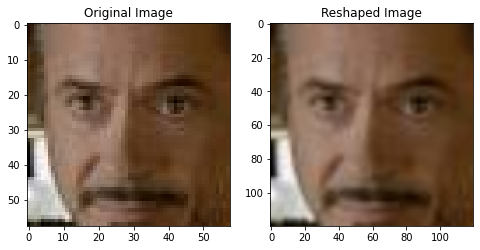

In [98]:
# Reshape the image.
img_reshaped_smallest = cv2.resize(sorted_images[0], (120, 120))

# Display the original and reshaped images side by side.
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# original image
axs[0].imshow(sorted_images[0])
axs[0].set_title("Original Image")

# reshape image
axs[1].imshow(img_reshaped_smallest)
axs[1].set_title("Reshaped Image")
plt.show()

## LBP Feature

In [99]:
def compute_lbp_feature(image, radius=3, n_points=24, method="uniform"):
    # Convert the image to grayscale.
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute the LBP feature vector for the grayscale image.
    lbp = local_binary_pattern(gray, n_points, radius, method=method)
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

    # Normalize the feature vector to have unit L1 norm.
    hist = hist.astype("float") / np.sum(hist)

    return lbp, hist

lbp_feature_s, hist_s = compute_lbp_feature(img_reshaped_smallest)
lbp_feature_l, hist_l = compute_lbp_feature(img_reshaped_largest)

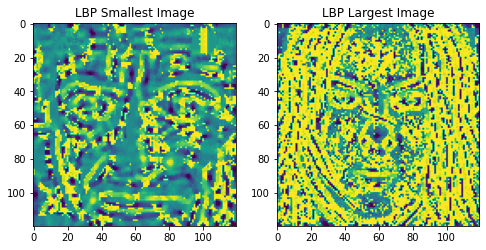

In [100]:
# Display the original and reshaped images side by side.
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# original image
axs[0].imshow(lbp_feature_s)
axs[0].set_title("LBP Smallest Image")

# reshape image
axs[1].imshow(lbp_feature_l)
axs[1].set_title("LBP Largest Image")
plt.show()

## HOG Feature

In [103]:
def compute_hog_features(image):
    # Convert the image to grayscale.
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Define the HOG parameters.
    orientations = 9
    pixels_per_cell = (8, 8)
    cells_per_block = (3, 3)

    # Compute the HOG feature vector and HOG image for the grayscale image.
    features, hog_image = hog(gray, orientations=orientations, pixels_per_cell=pixels_per_cell,
                              cells_per_block=cells_per_block, block_norm="L2-Hys", visualize=True)

    # Return the feature vector and HOG image.
    return features, hog_image


hog_feature_s, hog_img_s = compute_hog_features(img_reshaped_smallest)
hog_feature_l, hog_img_l = compute_hog_features(img_reshaped_largest)

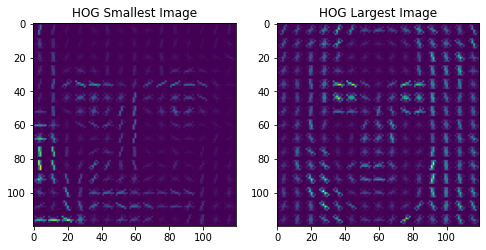

In [104]:
# Display the original and reshaped images side by side.
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# original image
axs[0].imshow(hog_img_s)
axs[0].set_title("HOG Smallest Image")

# reshape image
axs[1].imshow(hog_img_l)
axs[1].set_title("HOG Largest Image")
plt.show()

## HOG + LBP Feature

In [3]:
def extract_features(img, resize_shape=(120, 120)):
    # Convert the image to grayscale.
    img = cv2.resize(img, resize_shape)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Compute the LBP feature vector for the grayscale image.
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray, n_points, radius, method="uniform")
    hist_lbp,_ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist_lbp = hist_lbp.astype("float") / np.sum(hist_lbp)
    
    # Compute the HOG feature vector for the grayscale image.
    orientations = 9
    pixels_per_cell = (8, 8)
    cells_per_block = (3, 3)
    features_hog,_ = hog(gray, orientations=orientations, pixels_per_cell=pixels_per_cell,
                                  cells_per_block=cells_per_block, block_norm="L2-Hys", visualize=True)
    
    # Concatenate the LBP and HOG feature vectors into a single feature vector.
    features = np.concatenate((hist_lbp, features_hog))
    
    return features

## Training model using SVM

In [4]:
def split_train_test(folder_name, train_perc=0.8):
    
    # Get the list of all images in the folder
    images = os.listdir(folder_name)
    
    # Calculate the number of images for train and test 
    # based on the percentage provided
    num_images = len(images)
    
    if num_images > 3:
        num_train_images = int(num_images * train_perc)
        num_test_images = num_images - num_train_images

        # Create train and test directories
        train_dir = os.path.join(folder_name, 'train')
        os.makedirs(train_dir, exist_ok=True)
        test_dir = os.path.join(folder_name, 'test')
        os.makedirs(test_dir, exist_ok=True)

        # Move images into train and test folders
        for i, image in enumerate(images):
            if "png" in image or "jpg" in image:
                src_path = os.path.join(folder_name, image)
                if i < num_train_images:
                    dst_path = os.path.join(train_dir, image)
                else:
                    dst_path = os.path.join(test_dir, image)
            os.rename(src_path, dst_path)

        print(f'{num_train_images} images moved to {train_dir}')
        print(f'{num_test_images} images moved to {test_dir}')
    
    else:
        print(f'Already move images in {folder_name} to train and test folders')

In [5]:
# Split images of avenger's folders to train and test
for folder in os.listdir(root_dir):
    if ".git" not in folder:
        split_train_test(os.path.join(root_dir, folder))

Already move images in /media/data/Project_Only/MLOps/face-rec-avenger/data/01_raw/chris_evans to train and test folders
Already move images in /media/data/Project_Only/MLOps/face-rec-avenger/data/01_raw/chris_hemsworth to train and test folders
Already move images in /media/data/Project_Only/MLOps/face-rec-avenger/data/01_raw/mark_ruffalo to train and test folders
Already move images in /media/data/Project_Only/MLOps/face-rec-avenger/data/01_raw/robert_downey_jr to train and test folders
Already move images in /media/data/Project_Only/MLOps/face-rec-avenger/data/01_raw/scarlett_johansson to train and test folders


In [6]:
X_train = []
y_train = []

X_test = []
y_test = []

for label in os.listdir(root_dir):
    if ".git" not in label:
        # Define the paths to the train and test data directories
        train_dir = os.path.join(root_dir, label, "train")
        test_dir = os.path.join(root_dir, label, "test")

        # Load the training data
        for filename in os.listdir(train_dir):
            if ".png" in filename or ".jpg" in filename:
                img = cv2.imread(os.path.join(train_dir, filename))
                X_train.append(extract_features(img))
                y_train.append(label)

        # Load the testing data
        for filename in os.listdir(test_dir):
            if ".png" in filename or ".jpg" in filename:
                img = cv2.imread(os.path.join(test_dir, filename))
                X_test.append(extract_features(img))
                y_test.append(label)

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
    
# Convert the data to NumPy arrays.
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# Train a SVM classifier on the training set.
svm = SVC(kernel="linear")
svm.fit(X_train, y_train)

SVC(kernel='linear')

In [9]:
from sklearn.model_selection import KFold

X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

kf = KFold(n_splits=10, shuffle=True)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Evaluate the accuracy of the classifier on the validation set.
    acc = svm.score(X_test, y_test)
    print(f"Train accuracy: {acc}")

Train accuracy: 1.0
Train accuracy: 1.0
Train accuracy: 0.9642857142857143
Train accuracy: 1.0
Train accuracy: 1.0
Train accuracy: 0.9629629629629629
Train accuracy: 1.0
Train accuracy: 1.0
Train accuracy: 1.0
Train accuracy: 0.9629629629629629


## Save model

In [15]:
import pickle

# Save the trained SVM model to a pickle file
save_model_weight_path = "/media/data/Project_Only/MLOps/face-rec-avenger/data/02_intermediate/svm_model.pkl"
with open(save_model_weight_path, 'wb') as f:
    pickle.dump(svm, f)

## Test 

Predicted label for new image: scarlett_johansson


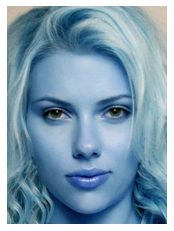

In [76]:
new_img = cv2.imread("/media/data/Project_Only/MLOps/test_imgs/scarlett.png")
new_features = extract_features(new_img)
new_label = svm.predict([new_features])[0]

print(f"Predicted label for new image: {new_label}")
plt.imshow(new_img)
plt.axis("off")
plt.show()

Predicted label for new image: mark_ruffalo


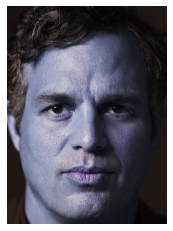

In [77]:
new_img = cv2.imread("/media/data/Project_Only/MLOps/test_imgs/mark-ruffalo.jpg")
new_features = extract_features(new_img)
new_label = svm.predict([new_features])[0]

print(f"Predicted label for new image: {new_label}")
plt.imshow(new_img)
plt.axis("off")
plt.show()

Predicted label for new image: chris_hemsworth


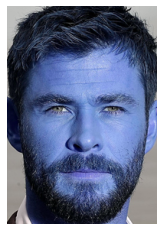

In [78]:
new_img = cv2.imread("/media/data/Project_Only/MLOps/test_imgs/Chris-Hemsworth.jpeg")
new_features = extract_features(new_img)
new_label = svm.predict([new_features])[0]

print(f"Predicted label for new image: {new_label}")
plt.imshow(new_img)
plt.axis("off")
plt.show()

Predicted label for new image: robert_downey_jr


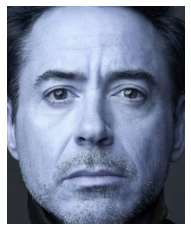

In [89]:
new_img = cv2.imread("/media/data/Project_Only/MLOps/test_imgs/robert.jpeg")
new_features = extract_features(new_img)
new_label = svm.predict([new_features])[0]

print(f"Predicted label for new image: {new_label}")
plt.imshow(new_img)
plt.axis("off")
plt.show()

Predicted label for new image: chris_evans


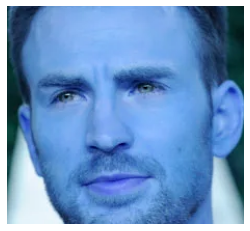

In [90]:
new_img = cv2.imread("/media/data/Project_Only/MLOps/test_imgs/Chris-Evans.png")
new_features = extract_features(new_img)
new_label = svm.predict([new_features])[0]

print(f"Predicted label for new image: {new_label}")
plt.imshow(new_img)
plt.axis("off")
plt.show()